<h1> HubMap - Hacking the Kidney </h1>
<h3> Goal - Mapping the human body at function tissue unit level - detect crypts FTUs in colon </h3>

Implementation of Kaggle Notebook - Innovation Prize Winner - Deep Flash2 <br>
Description - Create segmentations masks from RLE and probability density function (PDF) for efficient sampling from mask and anatmical structure. <br>
Input - train.csv (csv file containing rle format mask), HuBMAP-20-dataset_information.csv (csv containing meta data about the images), downscaled images <br>
- Sampling weight for cortex regions (`cortex_value`): 0.5 
- Sampling weight for medulla regions (`medulla_value`): 0.25
- Sampling weight for other regions (`fbr`, foreground-background-ratio): 0.01  

Output - downscaled masks, roi-stats.csv (csv containing pdfs for each image) <br> 

<b>How to use?</b><br> 
Change the basepath to where your data lives and you're good to go. <br>

Link to the original notebook - https://www.kaggle.com/matjes/hubmap-efficient-sampling-ii-deepflash2#HuBMAP-masks-and-probability-density-function <hr>

<h6> Step 1 - Import useful libraries<h6>

In [1]:
import cv2, zarr, gc
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
gc.enable()

In [2]:
# from https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

<h6> Step 2 - Set paths and configuration </h6>

In [3]:
path = Path(r'../../../Colonic_crypt_dataset')
df_train = pd.read_csv(path/"train.csv")
df_info = pd.read_csv(path/"colon-dataset_information.csv")
grp_pdf = zarr.open_group('../../../Colonic_crypt_dataset/zarr/images_scale2/')

class CONFIG:
    scale = 2        # Downscale final mask by factor 2
    cdf_size = 512   # Downscale CDF for memory efficient loading during training
    bg_p = 0.1       # Background Probability
    cortex_p = 0.9   # Cortex Probability
    #medulla_p = 0.2  # Medulla Probability
    
cfg = CONFIG()

# Output
root = zarr.group(f'../../../Colonic_crypt_dataset/zarr/masks_scale{cfg.scale}')
# Saving cdf in 'pdfs' due to naming conventions for sampling during training in deepflash2
g_msk, g_pdf, g_cdf = root.create_groups('labels', 'pdfs', 'cdfs', overwrite=True)

In [4]:
df_train = df_train.rename(columns={"predicted":"encoding"})
df_train = df_train[df_train.id != 'HandE_B005_CL_b_RGB_topright']

In [5]:
df_train.index = df_train.id

<h6> Step 3 - Resize the masks and find the pdf for each image </h6>

Scaling to (2352, 2268)
Getting glomeruli stats
Found 34 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


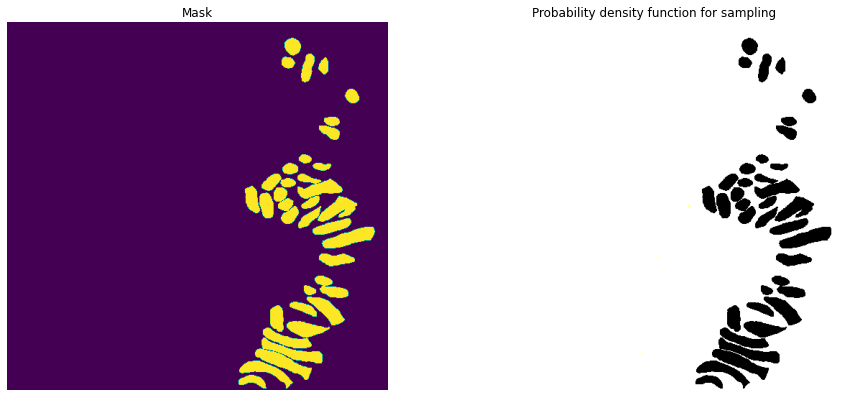

Scaling to (2352, 2268)
Getting glomeruli stats
Found 85 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


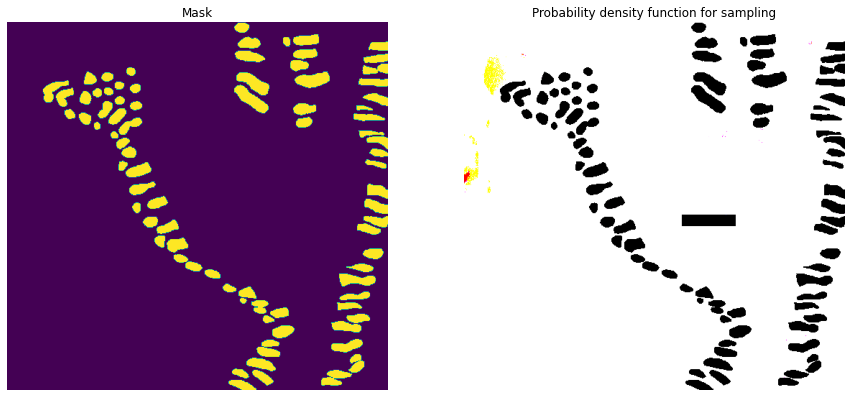

Scaling to (2352, 2268)
Getting glomeruli stats
Found 37 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


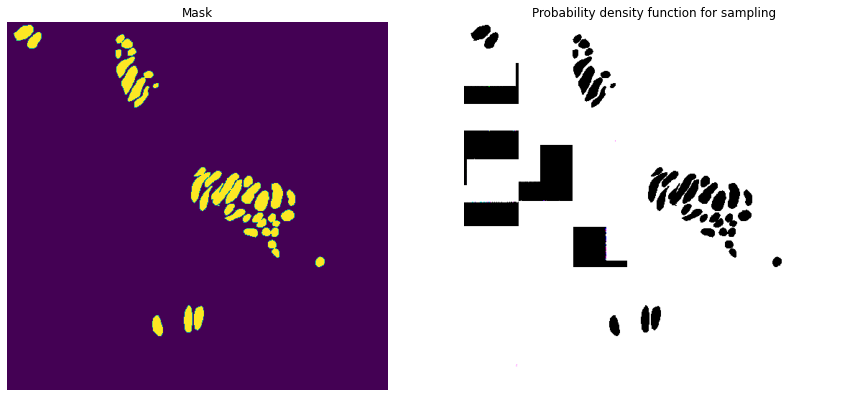

Scaling to (2352, 2268)
Getting glomeruli stats
Found 38 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


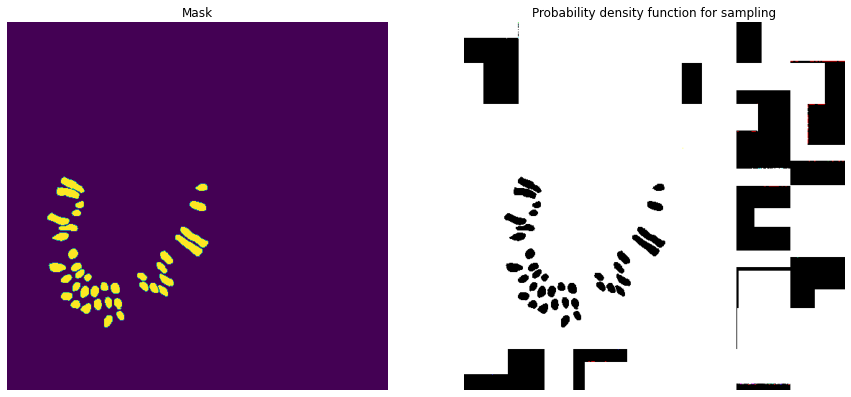

Scaling to (2352, 2268)
Getting glomeruli stats
Found 31 glomeruli


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


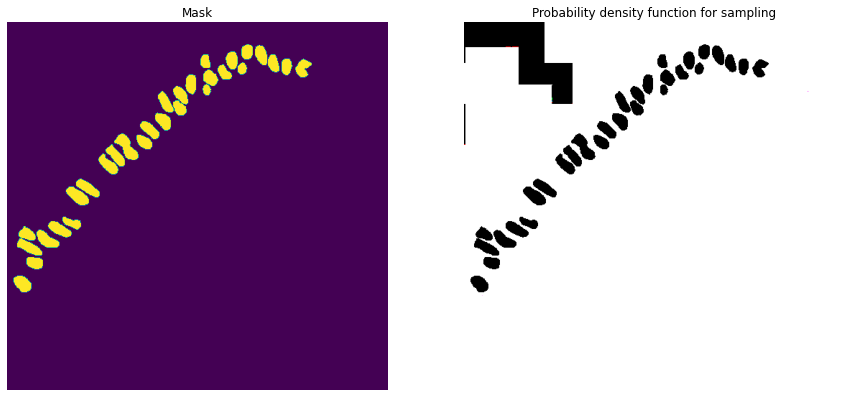

cy           cx  left   top  \
idx                            index                                         
CL_HandE_1234_B004_bottomright 0      1763.353125   150.542281  1713    99   
                               1      1855.790984   282.086506  1815   193   
                               2      1734.037932   249.612130  1695   214   
                               3      1956.836915   271.485461  1923   215   
                               4      2130.578245   456.452286  2087   410   
...                                           ...          ...   ...   ...   
HandE_B005_CL_b_RGB_topleft    25      124.010706  1307.721979    71  1258   
                               26      247.096241  1343.458110   182  1280   
                               27      136.997785  1389.267804    61  1332   
                               28      171.262852  1483.713127   118  1446   
                               29       96.196463  1612.960998    40  1564   

                                      width  height   area  
idx                            index                        
CL_HandE_1234_B004_bottomright 0        101     107   8337  
                               1         86     180  10138  
                               2         83      72   4798  
                               3         63     110   4746  
                               4         89      91   5994  
...                                     ...     ...    ...  
HandE_B005_CL_b_RGB_topleft    25       106      90   6165  
                               26       143     113   9310  
                               27       158     109   9029  
                               28       105      78   6536  
                               29       111     104   8256  

[220 rows x 7 columns]

In [8]:
df_list = []
for idx, row in df_train.iterrows():
    # Get image info
    img_info = df_info[df_info.image_file==f'{idx}']
    shape = (img_info.height_pixels.values[0], img_info.width_pixels.values[0])
    
    msk = rle2mask(row.encoding, (shape[1], shape[0])).astype('uint8')
    
    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    resize_w = int((msk.shape[1]/msk.shape[0])*cfg.cdf_size)
    ax[0].imshow(cv2.resize(msk, dsize=(resize_w, cfg.cdf_size)))
    ax[0].set_title('Mask')
    ax[0].set_axis_off()
    
    pdf = grp_pdf[idx][:]
    
    if cfg.scale!=1:
        new_size = (msk.shape[1] // cfg.scale, msk.shape[0] // cfg.scale)
        print('Scaling to', new_size)
        msk = cv2.resize(msk, new_size)
        pdf = cv2.resize(pdf, new_size)
        
    pdf = pdf.astype('float32')          
    pdf[pdf==0] = cfg.bg_p/np.sum(pdf==0)
    pdf[msk>0] = 0
    pdf[pdf==1] = cfg.cortex_p/np.sum(pdf==1)
    #pdf[pdf==2] = cfg.medulla_p/np.sum(pdf==2)    
      
    print('Getting glomeruli stats')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(msk, connectivity=4)
    print(f'Found {nb_components} glomeruli')
    df_centroids = pd.DataFrame(centroids[1:], columns=['cy', 'cx'])
    df_centroids = df_centroids.join(pd.DataFrame(stats[1:], columns=['left', 'top', 'width', 'height', 'area']))
    df_centroids['idx'] = idx 
    df_centroids.reset_index(inplace=True)
    df_centroids.set_index(['idx', 'index'], inplace=True)
    df_list.append(df_centroids)
    
    # Saving 
    g_msk[idx] = msk
    g_pdf[idx] = pdf
    
    # Saving cdf
    pdf = cv2.resize(pdf, dsize=(resize_w, cfg.cdf_size))      
    g_cdf[idx] = np.cumsum(pdf/np.sum(pdf)) 
            
    ax[1].imshow(pdf)
    ax[1].set_title('Probability density function for sampling')
    ax[1].set_axis_off() 
    plt.show()


df_stats = pd.concat(df_list)
df_stats.to_csv(f'../../../Colonic_crypt_dataset/zarr/masks_scale{cfg.scale}/roi_stats.csv')
df_stats